In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

C:\tools\Anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
"""
Two different methods for reading training and testing images since train_files.csv does not preserve order of files in the training images folder
"""

'\nTwo different methods for reading training and testing images since train_files.csv does not preserve order of files in the training images folder\n'

In [3]:
def read_training_images(train_files, train_dir):
    """
    A method that reads the training image files in a given directory and returns the list of all images as numpy arrays
    """

    images=[]
    n=0
    for img_name in train_files.file_name:
        image_path = os.path.join(train_dir, img_name)
        img = cv2.imread(image_path)
        # img = np.expand_dims(cv2.resize(img, dsize=(COLS, ROWS), interpolation=cv2.INTER_CUBIC), axis=2)
        # .flatten()
        # print(n)
        # print(type(img))
        # print(img.shape)
        # cv2.imshow('image', img)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        img = img.astype('float32')
        images.append(img)
        n+=1
    print("Number of training images read = {}".format(n))

    return images

In [4]:
def read_testing_images(directory):
    """
    A method that reads the test image files in a given directory and returns the list of all images as numpy arrays
    """
    files = os.listdir(directory)

    images=[]
    m=0
    for fil in files:
        image_path = os.path.join(directory, fil)
        img = cv2.imread(image_path)
        # img = np.expand_dims(cv2.resize(img, dsize=(COLS, ROWS), interpolation=cv2.INTER_CUBIC), axis=2)
        img = img.astype('float32')
        images.append(img)
        m+=1
    print("Number of testing images read = {}".format(m))

    return images

In [5]:
def custom_vgg16(layer1_size=512, layer2_size=512, layer3_size=256, dropout=0.3, activation="relu", cols=480, rows=640, channel=3):
    """
    A model that generates a custom VGG16 model by adding dense layer to its bottom.
    The top layers from VGG16 were not used. The extracted VGG16 layers were used for
    feature representation and hence were not made trainable (frozen).
    This function retuns a custom VGG16 model with all the layers added. 
    """

    
    # initialize the VGG16 model from the keras library
    vgg16_model = tf.keras.applications.VGG16(include_top=False,
                                              weights='imagenet',
                                              input_tensor=None,
                                              input_shape=(cols, rows, channel),
                                              pooling=None,
                                              classes=5)

    model = tf.keras.Sequential()

    for layer in vgg16_model.layers[:-1]: 
        model.add(layer)


    # Freeze the layers
    for layer in model.layers:
        layer.trainable = False

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(layer1_size, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(layer2_size, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(layer3_size, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout))
    # model.add(tf.keras.layers.Dense(layer4_size, activation=activation))
    # model.add(tf.keras.layers.Dropout(dropout))

    # Add 'softmax' instead of earlier 'prediction' layer.
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    return model

In [6]:
def generate_plots(model_history, epochs):
    """
    A method that takes the model history of a trained model and plots its:
    1. Training accuracy
    2. Training loss
    3. Validation accuracy
    4. Validation loss
    """
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']


    plt.figure(1)
    plt.suptitle('Accuracy learning curve', fontsize=20)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    plt.plot(acc, label='training accuracy')
    plt.plot(val_acc, label='validation accuracy')
    plt.xticks(np.arange(0, epochs, epochs/10))
    plt.legend(loc="lower right")
    plt.savefig("accuracy.png", dpi=300)

    plt.figure(2)
    plt.suptitle('Loss learning curve', fontsize=20)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.plot(loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xticks(np.arange(0, epochs, epochs/10))
    plt.legend(loc="upper right")
    plt.savefig("loss.png", dpi=300)

In [7]:
def best_results(model_history):
    """
    A method that prints the best validation accuracy and loss to a best_results.txt file.
    """
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    
    f = open("best_results.txt", "w+")
    f.write("Training accuracy = {}\n".format(acc))
    f.write("----------------------\n")
    f.write("Training loss = {}\n".format(loss))
    f.write("----------------------\n")
    f.write("Validation accuracy = {}\n".format(val_acc))
    f.write("----------------------\n")
    f.write("Validation loss = {}\n".format(val_loss))
    f.write("----------------------\n")
    f.write("----------------------\n\n")
    f.close()

In [8]:

# Initialize the directories
root_dir = os.path.abspath('./')
train_dir = os.path.join(root_dir, 'Training')
test_dir = os.path.join(root_dir, 'Project_C2_Testing')


train_files = pd.read_csv(os.path.join(root_dir, 'train_files.csv'))

# set constants
COLS, ROWS, CHANNEL = 480, 640, 3

# training constants
EPOCHS = 30
BATCH_SIZE = 16

# read the training and testing images
training_images = read_training_images(train_files, train_dir)
testing_images = read_testing_images(test_dir)


X_train = np.stack(training_images)
y_train = train_files.annotation.values
X_test = np.stack(testing_images)


# Split the training data in training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=None, shuffle=True, stratify=y_train)

print("Shape of training set: {}".format(X_train.shape))
print("Shape of validation set: {}".format(X_val.shape))
print("Shape of testing set: {}".format(X_test.shape))    

Number of training images read = 896
Number of testing images read = 129
Shape of training set: (716, 480, 640, 3)
Shape of validation set: (180, 480, 640, 3)
Shape of testing set: (129, 480, 640, 3)


In [9]:
print("-------------------")
print("Compiling model")
print("-------------------")

# initialize the model
model = custom_vgg16(512, 512, 256, 0.4, "relu", COLS, ROWS, CHANNEL)

model.summary()

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

-------------------
Compiling model
-------------------
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 480, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 320, 128)     147584    
_________________________________________________________________
block2_pool (M

-------------------
Training model
-------------------
Train on 716 samples, validate on 180 samples
Epoch 1/30
716/716 [==============================] - 19s 27ms/sample - loss: 87.4070 - acc: 0.4372 - val_loss: 12.9324 - val_acc: 0.5722
Epoch 2/30
716/716 [==============================] - 13s 18ms/sample - loss: 32.0457 - acc: 0.6229 - val_loss: 11.5751 - val_acc: 0.6944
Epoch 3/30
716/716 [==============================] - 13s 18ms/sample - loss: 16.5424 - acc: 0.7053 - val_loss: 5.9246 - val_acc: 0.7611
Epoch 4/30
716/716 [==============================] - 13s 18ms/sample - loss: 12.7750 - acc: 0.7207 - val_loss: 6.0757 - val_acc: 0.7556
Epoch 5/30
716/716 [==============================] - 13s 18ms/sample - loss: 8.2458 - acc: 0.7793 - val_loss: 7.9201 - val_acc: 0.7444
Epoch 6/30
716/716 [==============================] - 13s 18ms/sample - loss: 8.9537 - acc: 0.7723 - val_loss: 4.0130 - val_acc: 0.7389
Epoch 7/30
716/716 [==============================] - 13s 18ms/sample - loss:

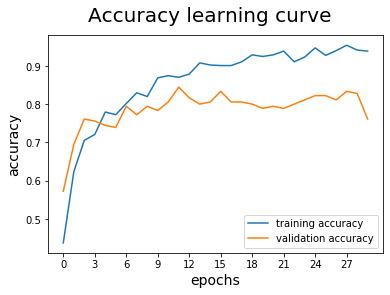

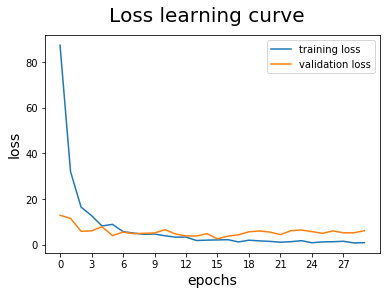

In [10]:
print("-------------------")
print("Training model")
print("-------------------")

with tf.device('/device:GPU:0'):
    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))


predictions = model.predict(X_test, batch_size=16)

generate_plots(history, EPOCHS)

best_results(history)

In [11]:
test_labels = np.asarray([np.argmax(prediction) for prediction in predictions])
np.savetxt("predictions.csv", test_labels, fmt="%d", delimiter=",")

In [15]:
test_labels = [np.argmax(prediction) for prediction in predictions]

import csv
with open('file.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(test_labels)